# Metrics time series

In [1]:
!make -C .. breakpoints

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'breakpoints'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import pylandstats as pls
import swisslandstats as sls
from shapely import geometry

from swiss_urbanization import settings, utils

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

In [3]:
agglom_slugs = ['bern', 'lausanne', 'zurich']

urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

class_metrics = [
    'proportion_of_landscape', 'area_mn',
    'patch_density', 'edge_density',
    'fractal_dimension_am', 'euclidean_nearest_neighbor_mn'
]
landscape_metrics = [
    'contagion', 'shannon_diversity_index'
]

# change PyLandStats metric labels in plots (use custom abbreviations)
pls.settings.metric_label_dict = settings.METRIC_LABEL_DICT

In [4]:
# auxiliary function to plot the time series of a metric for all agglomerations
# in one axis
def plot_metric_all_aggloms(ax, metric, agglom_dict, class_val=None):
    for agglom_slug in agglom_dict:
        agglom_dict[agglom_slug].plot_metric(
            metric,
            class_val=class_val,
            ax=ax,
            plot_kws={'label': agglom_slug.capitalize()})
    ax.margins(y=.5)
    ax.legend()

In [5]:
agglom_extent_dict = {}
for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes, dates = utils.get_landscapes_and_dates(ldf, nodata)
    agglom_extent_dict[agglom_slug] = pls.SpatioTemporalAnalysis(landscapes,
                                                                 dates=dates)

## Selecting metrics

Following the thorough works of Wu et al. [1,2], a set of 8 metrics have been chosen by their suitability for landscape studies and their robustness when exposed to changes in scale, i.e., grain and extent (seealso the [`sensitivity_extent.ipynb`](https://github.com/martibosch/swiss-urbanization/blob/master/notebooks/sensitivity_extent.ipynb))

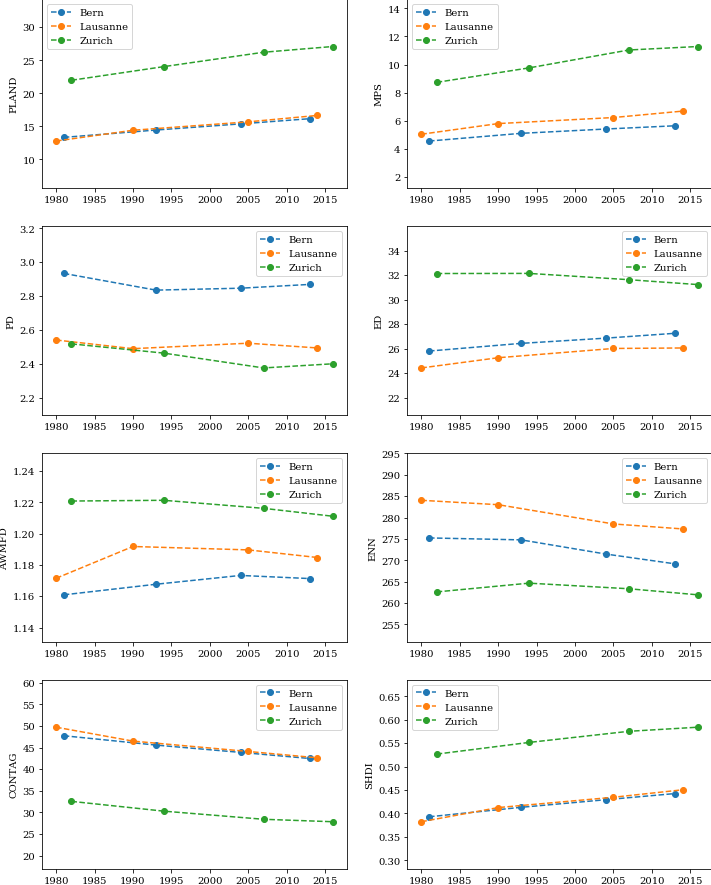

In [6]:
num_cols = 2
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_aggloms(ax,
                            metric,
                            agglom_extent_dict,
                            class_val=urban_class)

for i, metric in enumerate(landscape_metrics, start=len(class_metrics) + 1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    plot_metric_all_aggloms(ax, metric, agglom_extent_dict)

### Metric correlations

In [7]:
metrics_df = pd.DataFrame(columns=class_metrics + landscape_metrics)

for agglom_slug in agglom_slugs:
    class_metrics_df = agglom_extent_dict[
        agglom_slug].compute_class_metrics_df(metrics=class_metrics,
                                              classes=[urban_class])
    landscape_metrics_df = agglom_extent_dict[
        agglom_slug].compute_landscape_metrics_df(metrics=landscape_metrics)
    agglom_metrics_df = pd.concat([
        class_metrics_df.loc[urban_class][class_metrics],
        landscape_metrics_df[landscape_metrics]
    ],
                                  axis=1)
    # need minmax scaling for correlations to work
    agglom_metrics_df = agglom_metrics_df.apply(pd.to_numeric).apply(
        lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0)
    metrics_df = pd.concat([metrics_df, agglom_metrics_df], ignore_index=True)

In [8]:
metrics_df.corr()

metric,proportion_of_landscape,area_mn,patch_density,edge_density,fractal_dimension_am,euclidean_nearest_neighbor_mn,contagion,shannon_diversity_index
metric,,,,,,,,
proportion_of_landscape,1.000000,0.994628,-0.715461,0.309929,0.182301,-0.730462,-0.997935,0.999642
area_mn,0.994628,1.000000,-0.774352,0.289020,0.189477,-0.691272,-0.993336,0.995257
patch_density,-0.715461,-0.774352,1.000000,-0.102047,-0.246814,0.258709,0.721802,-0.723753
edge_density,0.309929,0.289020,-0.102047,1.000000,0.874120,-0.429082,-0.327796,0.316953
fractal_dimension_am,0.182301,0.189477,-0.246814,0.874120,1.000000,-0.192097,-0.209405,0.196659
euclidean_nearest_neighbor_mn,-0.730462,-0.691272,0.258709,-0.429082,-0.192097,1.000000,0.703581,-0.718007
contagion,-0.997935,-0.993336,0.721802,-0.327796,-0.209405,0.703581,1.000000,-0.999165
shannon_diversity_index,0.999642,0.995257,-0.723753,0.316953,0.196659,-0.718007,-0.999165,1.000000


It is clear that PLAND, MPS, CONTAG and SHDI have a strong Pearson correlation, with its absolute value being greater than 0.99.

## Analysis with the chosen metrics

In [6]:
class_metrics = [
    'proportion_of_landscape', 'patch_density', 'edge_density',
    'fractal_dimension_am', 'euclidean_nearest_neighbor_mn'
]

base_mask_dict = settings.BASE_MASK_DICT
base_mask_crs = settings.BASE_MASK_CRS
max_buffer_dist = settings.MAX_BUFFER_DIST

In [7]:
agglom_inner_dict = {}
agglom_outer_dict = {}

for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes, dates = utils.get_landscapes_and_dates(ldf, nodata)
    with open(f'../data/processed/breakpoints/{agglom_slug}.json') as fp:
        agglom_bkps = json.load(fp)
    # we will pick the breakpoint observed in the last period of study
    bkp = agglom_bkps[-1]
    agglom_stba = pls.SpatioTemporalBufferAnalysis(
        landscapes,
        base_mask_dict[agglom_slug],
        buffer_rings=True,
        buffer_dists=[bkp, max_buffer_dist],
        base_mask_crs=base_mask_crs,
        landscape_crs=ldf.crs,
        landscape_transform=ldf.get_transform(),
        dates=dates)
    agglom_inner_dict[agglom_slug] = agglom_stba.stas[0]
    agglom_outer_dict[agglom_slug] = agglom_stba.stas[-1]

In [9]:
agglom_inner_dict['bern'].compute_class_metrics_df(metrics=['fractal_dimension_am'], classes=[1])

metric          fractal_dimension_am
class_val dates                     
1         1981               1.21848
          1993               1.21236
          2004               1.20774
          2013               1.20177

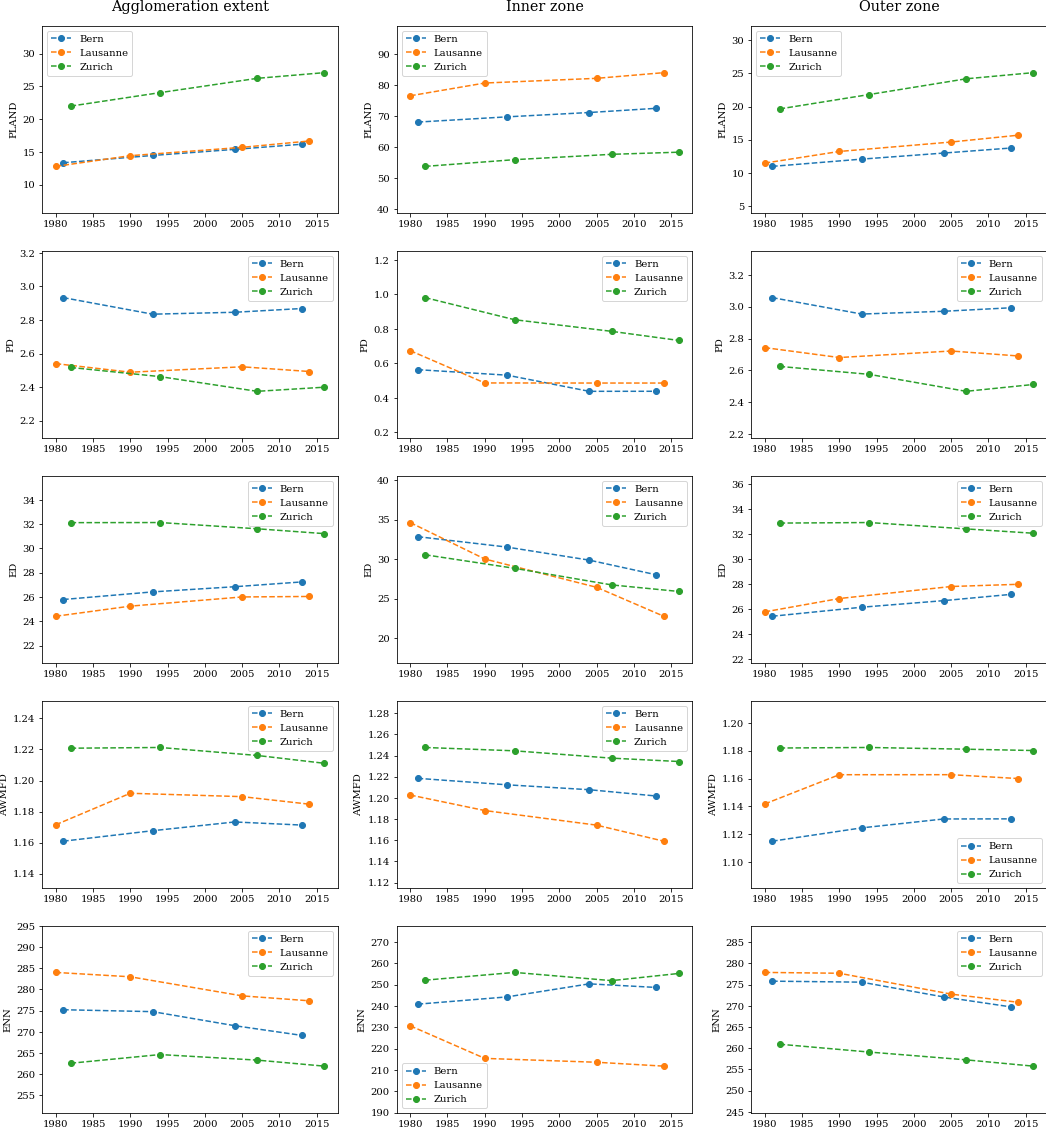

In [11]:
num_cols = 3
num_metrics = len(class_metrics)  # + len(landscape_metrics)
num_rows = num_metrics

fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics):
    for j, agglom_dict in enumerate(
        (agglom_extent_dict, agglom_inner_dict, agglom_outer_dict), start=1):
        ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j)
        plot_metric_all_aggloms(ax, metric, agglom_dict, class_val=urban_class)

for ax, extent in zip(fig.axes[:num_cols],
                      ('Agglomeration extent', 'Inner zone', 'Outer zone')):
    ax.set_title(extent, fontsize='x-large', pad=15)

fig.savefig('../reports/figures/metrics_time_series.eps')

## References

1. Jianguo Wu, Weijun Shen, Weizhong Sun, and Paul T Tueller. Empirical patterns of the effects of changing scale on landscape metrics. Landscape Ecology, 17(8):761–782, 2002
2. Jianguo Wu. Effects of changing scale on landscape pattern analysis: scaling relations. Landscape ecology, 19(2):125–138, 2004.